In [1]:
# This demo code is inspired by https://github.com/facebookresearch/ToMe/blob/main/examples/0_validation_timm.ipynb.
import torch
import matplotlib.pyplot as plt
import argparse
import tqdm
import sys

In [2]:
# pre-trained weights
!gdown -O ckpt/model-790000.ckpt 1PUePrc-xsKTNqxQ9V9T0qVEQGsFxcKJY

# compressed weights
!gdown -O ckpt/ddpm_tl38.0_ckpt_100000.pth 1nT2KpEjWrl9s3Y5TabYdZPxdP2oLyBk7

Downloading...
From (original): https://drive.google.com/uc?id=1PUePrc-xsKTNqxQ9V9T0qVEQGsFxcKJY
From (redirected): https://drive.google.com/uc?id=1PUePrc-xsKTNqxQ9V9T0qVEQGsFxcKJY&confirm=t&uuid=b2a12fe4-df9e-47e8-88d2-00902c5566ef
To: /data_fast/home/jusjinuk/codes/LayerMerge/examples/ckpt/model-790000.ckpt
100%|████████████████████████████████████████| 143M/143M [00:19<00:00, 7.34MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1nT2KpEjWrl9s3Y5TabYdZPxdP2oLyBk7
From (redirected): https://drive.google.com/uc?id=1nT2KpEjWrl9s3Y5TabYdZPxdP2oLyBk7&confirm=t&uuid=a69985a2-ab85-4e48-b357-13f26d41050f
To: /data_fast/home/jusjinuk/codes/LayerMerge/examples/ckpt/ddpm_tl38.0_ckpt_100000.pth
100%|████████████████████████████████████████| 504M/504M [00:57<00:00, 8.72MB/s]


In [3]:
sys.path.append('../Diff-Pruning/exp_code')
from functions.denoising import generalized_steps
import torchvision.utils as tvu
import numpy as np

def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    if beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

betas = get_beta_schedule(
    beta_schedule='linear',
    beta_start=0.0001,
    beta_end=0.02,
    num_diffusion_timesteps=1000,
)
betas = torch.from_numpy(betas).float().to("cuda")
num_timesteps = betas.shape[0]

def sample_image(x, model, last=True):
    timesteps = 100
    seq = (
        np.linspace(
            0, np.sqrt(num_timesteps * 0.8), timesteps
        )
        ** 2
    )
    seq = [int(s) for s in list(seq)]


    xs = generalized_steps(x, seq, model, betas, eta=0)
    x = xs
    if last:
        x = x[0][-1]
    return x

def inverse_data_transform(X):
    X = (X + 1.0) / 2.0
    return torch.clamp(X, 0.0, 1.0)

def set_random_seed(seed=42):
    # Set the random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


In [4]:
# Visualize the sampled images
def sample_and_vis(inp, model):
    with torch.no_grad():

        x = sample_image(inp, model)
        x = inverse_data_transform(x)
        grid = tvu.make_grid(x)

    # Convert the grid to a numpy array
    grid_np = grid.cpu().numpy()

    # Transpose the dimensions to be in the correct order for matplotlib (H, W, C)
    grid_np = grid_np.transpose((1, 2, 0))

    plt.figure(figsize=(5, 5))
    plt.imshow(grid_np)
    
# Measuer inference time
def sample_time(model):
    img_id = 0
    batch_size = 128
    print(f"batch size {batch_size}")
    total_n_samples = batch_size * 5
    n_rounds = (total_n_samples - img_id) // batch_size

    warmup = 2
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(
        enable_timing=True
    )
    timings = np.zeros((n_rounds, 1))

    with torch.no_grad():
        for _ in tqdm.tqdm(
            range(warmup), desc="Warmup GPU."
        ):
            n = batch_size
            x = torch.randn(n, 3, 32, 32, device=torch.device('cuda'))
            x = sample_image(x, model)

    with torch.no_grad():
        for rep_ in tqdm.tqdm(
            range(n_rounds), desc="Generating image samples for inference time measurement."
        ):
            n = batch_size
            x = torch.randn(n, 3, 32, 32, device=torch.device('cuda'))

            starter.record()
            x = sample_image(x, model)
            ender.record()
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep_] = curr_time

    mean_syn = np.sum(timings) / n_rounds
    std_syn = np.std(timings)
    thpts = 1 / (timings * 0.001) * batch_size
    mean_thpt = np.sum(thpts) / n_rounds
    std_thpt = np.std(thpts)
    return mean_syn, std_syn, mean_thpt, std_thpt

In [5]:
sys.path.append('../Diff-Pruning/exp_code')
from models.diffusion import Model
import yaml

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

# parse config file
with open("ddpm_cifar10.yml", "r") as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

pretrained_model = Model(config)
pretrained_path = 'ckpt/model-790000.ckpt'
print("Loading checkpoint {}".format(pretrained_path))
device = torch.device("cuda")
states = torch.load('ckpt/model-790000.ckpt', map_location=device)
pretrained_model.load_state_dict(states, strict=True)
pretrained_model.to(device)
pretrained_model.eval()
pretrained_model

Loading checkpoint ckpt/model-790000.ckpt


Model(
  (temb): Module(
    (dense): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(i

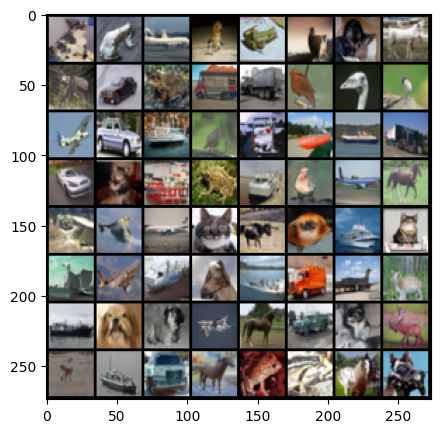

In [6]:
set_random_seed()
n = 64
inp = torch.randn(n, 3, 32, 32, device='cuda')

sample_and_vis(inp, pretrained_model)

In [7]:
sys.path.append('../Diff-Pruning/exp_code')
compressed_path = 'ckpt/ddpm_tl38.0_ckpt_100000.pth'
print("Loading checkpoint {}".format(compressed_path))
device = torch.device("cuda")
states = torch.load(compressed_path, map_location=device)
compressed_model = states[0].to(device)
print(f"act_pos: {list(compressed_model.act_pos)}")
print(f"conv_pos: {list(compressed_model.conv_pos)}")

Loading checkpoint ckpt/ddpm_tl38.0_ckpt_100000.pth
act_pos: [0, 1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 44, 45, 47, 49, 51, 52]
conv_pos: [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 41, 43, 46, 48, 50, 52]


In [8]:
compressed_model.merge()
compressed_model.eval()
compressed_model

DepthLayerDDPMModel(
  (temb): Module(
    (dense): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): DepthLayerResnetBlockMerged(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (postnorm): GroupNorm(32, 128, eps=1e-05, affine=True)
          (nonlinear): Swish()
          (nonlinear1): Swish()
          (merged_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): DepthLayerResnetBlockMerged(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (postnorm): GroupNorm(32, 128, eps=1e-05, affine=Tru

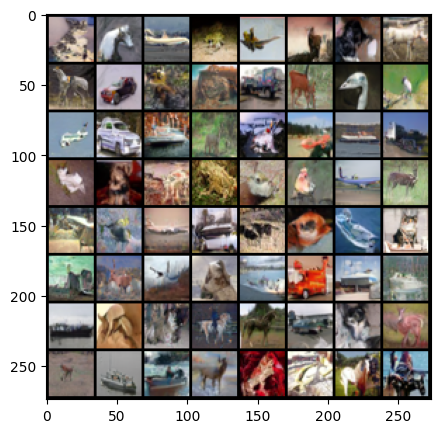

In [9]:
set_random_seed()
n = 64
inp = torch.randn(n, 3, 32, 32, device='cuda')

sample_and_vis(inp, compressed_model)

In [10]:
pt_lat_mean, pt_lat_std, pt_thpt_mean, pt_thpt_std = sample_time(pretrained_model)
print(f"Mean latency of pre-trained model: {pt_lat_mean}")
print(f"Mean throughput of pre-trained model: {pt_thpt_mean}")

batch size 128


Warmup GPU.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.08s/it]
Generating image samples for inference time measurement.: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.21s/it]

Mean latency of pre-trained model: 12207.072265625
Mean throughput of pre-trained model: 10.485818105464153


In [11]:
cmp_lat_mean, cmp_lat_std, cmp_thpt_mean, cmp_thpt_std = sample_time(compressed_model)
print(f"Mean latency of compressed model: {cmp_lat_mean}")
print(f"Mean throughput of compressed model: {cmp_thpt_mean}")

batch size 128


Warmup GPU.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.61s/it]
Generating image samples for inference time measurement.: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.61s/it]

Mean latency of compressed model: 9605.0650390625
Mean throughput of compressed model: 13.326322263490487


In [12]:
# Calculate the speedup
speedup = (cmp_thpt_mean / pt_thpt_mean)

# Print the speedup
print(f"Inference Speedup: {speedup:.2f}x")

Inference Speedup: 1.27x
